In [1]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
import os
print(sys.version)
print(keras.__version__)
print(tf.__version__)

3.6.0 (default, Jul 21 2017, 18:38:06) 
[GCC 4.8.4]
2.0.6
1.2.0


In [3]:
import matplotlib.pyplot as plt
import numpy as np

### Data preparation

In [7]:
from sklearn.model_selection import train_test_split 
def prepTest(sdirectory, tdirectory, test_size=0.20):
    for c in os.listdir(sdirectory):
        files = os.listdir(os.path.join(sdirectory,c))
        train,test = train_test_split(files, test_size = test_size)
        for file in train:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'train',c,file))
        for file in test:
            os.renames(os.path.join(sdirectory,c,file), os.path.join(tdirectory,'validate',c,file))

In [51]:
prepTest('train','data')

In [9]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '../data/train',  # this is the target directory
        target_size=(96, 96),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '../data/validate',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='categorical')

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [10]:
predict_datagen = ImageDataGenerator(rescale=1./255)
predict_generator = predict_datagen.flow_from_directory(
        '../validate',
        target_size=(96,96),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 3000 images belonging to 1 classes.


In [11]:
class PlotLosses(keras.callbacks.Callback):
    from IPython.display import clear_output
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        from IPython.display import clear_output
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        f, (ploss, pacc) = plt.subplots(1,2)
        f.set_figwidth(12)
        ploss.plot(self.x, self.losses, label="loss")
        ploss.plot(self.x, self.val_losses, label="val_loss")
        ploss.legend()
        pacc.plot(self.x, self.acc, label="acc")
        pacc.plot(self.x, self.val_acc, label="val_acc")
        pacc.legend()
        plt.show();
        
plot_losses = PlotLosses()

### Model

In [73]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, Nadam
from keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(96, 96, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Nadam(lr=0.002),
              metrics=['accuracy'])

#### LearningRateScheduler

In [75]:
# LearningRateScheduler
def step_decay(epoch):
    import math
    initial_lrate = 0.002
    drop = 0.8
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print(lrate)
    return lrate

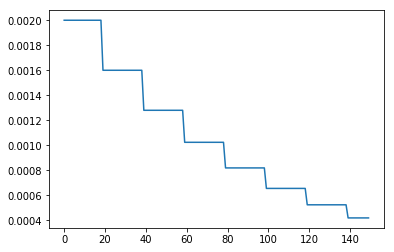

In [71]:
plt.plot([step_decay(i) for i in range(150)])
plt.show()

#### Fit Model

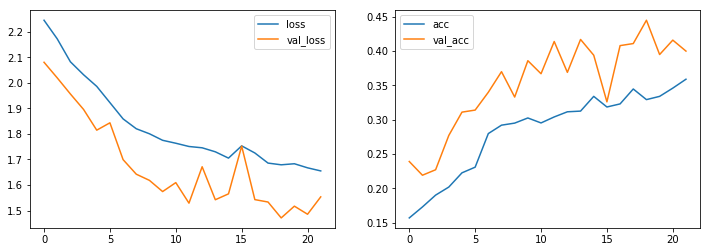

125/125 [==============================] - 10s - loss: 1.6552 - acc: 0.3590 - val_loss: 1.5537 - val_acc: 0.4000
0.0016
Epoch 23/200
 80/125 [==================>...........] - ETA: 3s - loss: 1.6435 - acc: 0.3473

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=4000 / batch_size,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[plot_losses, LearningRateScheduler(step_decay)],
        validation_steps=1000 / batch_size)

### Старые картинки

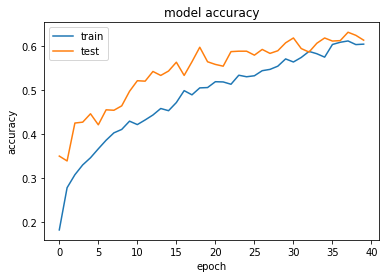

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

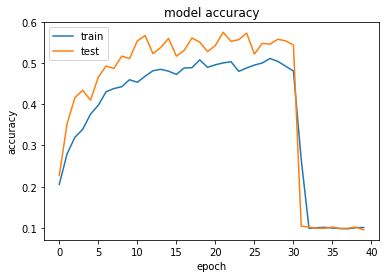

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

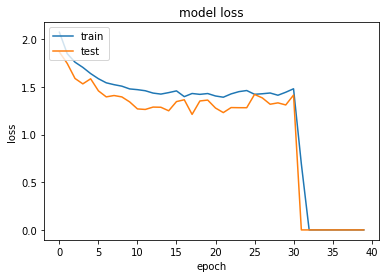

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

In [45]:
predicted = model.predict_generator(predict_generator, 3000 / batch_size)

In [46]:
predicted

array([[  1.28116021e-02,   1.96705023e-05,   2.32859934e-03, ...,
          1.33484733e-07,   8.32156539e-01,   1.52005047e-01],
       [  2.36228175e-06,   9.66308406e-04,   5.56521584e-08, ...,
          1.43933878e-03,   1.03960369e-08,   4.20029937e-05],
       [  9.14818840e-04,   1.00260267e-09,   4.98364389e-01, ...,
          9.88346696e-11,   1.86293619e-03,   4.98856783e-01],
       ..., 
       [  3.46714794e-03,   3.66190046e-01,   1.77245622e-03, ...,
          1.82611316e-01,   4.86568548e-04,   1.35337922e-03],
       [  9.15717721e-01,   8.19743946e-02,   3.28684720e-04, ...,
          3.28682981e-05,   4.33691093e-05,   1.25942822e-03],
       [  6.84052467e-01,   7.10841715e-02,   1.62447155e-01, ...,
          1.47358351e-03,   2.29535233e-02,   5.04043587e-02]], dtype=float32)

In [47]:
import re
import pandas as pd
output = pd.DataFrame({
            'uid': [re.match(r'validate/(.*).png',f).group(1) for f in predict_generator.filenames],
            'classes': [list(train_generator.class_indices)[np.argmax(p)] for p in predicted]}) \
        .reindex_axis(['uid','classes'],axis=1) \
        .set_index('uid')

In [48]:
print(output.shape)
output.head(3)

(3000, 1)


,classes
uid,
ship-file0280,ship
horse-file0247,horse
truck-file0296,truck


In [54]:
submission = pd.read_csv('dl_lab_pictures.csv',sep='\t', index_col='uid')

In [55]:
submission['classes']=output['classes']
submission = submission.reset_index()
print(submission.shape)
submission.head(3)

(3000, 3)


,uid,index,classes
0,airplane-file0000,0,airplane
1,airplane-file0001,1,airplane
2,airplane-file0002,2,airplane


In [56]:
submission.to_csv('dl_lab_pictures.csv',sep='\t',index=False)

In [31]:
#os.system("scp labwork/submission.csv dl.alexey.naydenov@cluster.newprolab.com:/data/home/dl.alexey.naydenov")